# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
from pathlib import Path
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_holes, remove_small_objects, label
from skimage.segmentation import watershed
from skimage.filters import sobel
from scipy import ndimage
from math import hypot
import pandas as pd
import numpy as np

import multiprocessing as mp
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:,.4f}'.format

# Filter-based prediction

# Analysis/Modeling
Do work here

In [21]:
repo_path = Path("/home/luca/PycharmProjects/cell_counting_yellow")
TRAIN_IMG_PATH = repo_path / "DATASET/OLD/sample_train/images"
TRAIN_MASKS_PATH = repo_path / "DATASET/OLD/sample_train/masks"

In [7]:
def mean_iou(y_true, y_pred):
    prec = []
    t = 0.95
    y_pred_ = tf.to_int32(y_pred > t)
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    prec.append(score)
    return K.mean(K.stack(prec), axis=0)

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

WeightedLoss = create_weighted_binary_crossentropy(1, 1.5)

In [9]:
from keras.models import load_model, Model, Sequential
from keras import backend as K
import tensorflow as tf

model_name = "ResUnet.h5"
model_path = "{}/model_results/{}".format(repo_path, model_name)

model = load_model(model_path, custom_objects={'mean_iou': mean_iou, 'dice_coef': dice_coef, 
                                                    'weighted_binary_crossentropy': WeightedLoss}, compile=False)   

In [10]:
def mask_post_processing(thresh_image, area_threshold=600, min_obj_size=200, max_dist=30):

    # Find object in predicted image
    labels_pred, nlabels_pred = ndimage.label(thresh_image)
    processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=8,
                                   in_place=False)
    processed = remove_small_objects(
        processed, min_size=min_obj_size, connectivity=1, in_place=False)
    labels_bool = processed.astype(bool)

    distance = ndimage.distance_transform_edt(processed)

    maxi = ndimage.maximum_filter(distance, size=max_dist, mode='constant')
    local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((40, 40)),
                                exclude_border=False,
                                labels=labels_bool)

    local_maxi = remove_small_objects(
        local_maxi, min_size=25, connectivity=1, in_place=False)
    markers = ndimage.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=labels_bool,
                       compactness=1, watershed_line=True)

    return(labels.astype("uint8")*255)


def make_UNet_prediction(img_path, threshold, model, colorspace="rgb"):

    # read input image
    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, 0)

    # compute prediction
    predicted_map = model.predict(img/255.)

    # threshold the predicted heatmap
    thresh_image = np.squeeze((predicted_map > threshold).astype('uint8'))
    thresh_image = mask_post_processing(thresh_image)

    return(thresh_image)


def compute_metrics(pred_mask_binary, mask, metrics, img_name):
    # extract predicted objects and counts
    pred_label, pred_count = ndimage.label(pred_mask_binary)
    pred_objs = ndimage.find_objects(pred_label)

    # compute centers of predicted objects
    pred_centers = []
    for ob in pred_objs:
        pred_centers.append(((int((ob[0].stop - ob[0].start)/2)+ob[0].start),
                             (int((ob[1].stop - ob[1].start)/2)+ob[1].start)))

    # extract target objects and counts
    targ_label, targ_count = ndimage.label(mask)
    targ_objs = ndimage.find_objects(targ_label)

    # compute centers of target objects
    targ_center = []
    for ob in targ_objs:
        targ_center.append(((int((ob[0].stop - ob[0].start)/2)+ob[0].start),
                            (int((ob[1].stop - ob[1].start)/2)+ob[1].start)))

    # associate matching objects, true positives
    tp = 0
    fp = 0
    for pred_idx, pred_obj in enumerate(pred_objs):

        min_dist = 50  # 1.5-cells distance is the maximum accepted
        TP_flag = 0

        for targ_idx, targ_obj in enumerate(targ_objs):

            dist = hypot(pred_centers[pred_idx][0]-targ_center[targ_idx][0],
                         pred_centers[pred_idx][1]-targ_center[targ_idx][1])

            if dist < min_dist:

                TP_flag = 1
                min_dist = dist
                index = targ_idx

        if TP_flag == 1:
            tp += 1
            TP_flag = 0

            targ_center.pop(index)
            targ_objs.pop(index)

    # derive false negatives and false positives
    fn = targ_count - tp
    fp = pred_count - tp

    # update metrics dataframe
    metrics.loc[img_name] = [tp, fp, fn, targ_count, pred_count]

    return(metrics)


def F1Score(metrics):
    # compute performance measure for the current quantile filter
    tot_tp_test = metrics["TP"].sum()
    tot_fp_test = metrics["FP"].sum()
    tot_fn_test = metrics["FN"].sum()
    tot_abs_diff = abs(metrics["Target_count"] - metrics["Predicted_count"])
    tot_perc_diff = (metrics["Predicted_count"] -
                     metrics["Target_count"])/(metrics["Target_count"]+10**(-6))
    accuracy = (tot_tp_test + 0.001)/(tot_tp_test +
                                      tot_fp_test + tot_fn_test + 0.001)
    precision = (tot_tp_test + 0.001)/(tot_tp_test + tot_fp_test + 0.001)
    recall = (tot_tp_test + 0.001)/(tot_tp_test + tot_fn_test + 0.001)
    F1_score = 2*precision*recall/(precision + recall)
    MAE = tot_abs_diff.mean()
    MedAE = tot_abs_diff.median()
    MPE = tot_perc_diff.mean()

    return(F1_score, MAE, MedAE, MPE, accuracy, precision, recall)

In [22]:
%%time
import multiprocessing as mp
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt


# create threshold grid for optimization
threshold_seq = np.arange(start=0.2, stop=0.9, step=0.05)
metrics_df_validation_rgb = pd.DataFrame(None, columns=["F1", "MAE", "MedAE", "MPE", "accuracy",
                                                        "precision", "recall"])

for _, threshold in tqdm(enumerate(threshold_seq), total=len(threshold_seq)):
    # create dataframes for storing performance measures
    validation_metrics_rgb = pd.DataFrame(
        columns=["TP", "FP", "FN", "Target_count", "Predicted_count"])

    # loop on training images
    for _, img_path in enumerate(TRAIN_IMG_PATH.iterdir()):
        mask_path = TRAIN_MASKS_PATH / img_path.name

        # compute predicted mask and read original mask
        img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)

        pred_mask_rgb = make_UNet_prediction(
            img_path, threshold, model)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        compute_metrics(pred_mask_rgb, mask,
                        validation_metrics_rgb, img_path.name)
    metrics_df_validation_rgb.loc[threshold] = F1Score(validation_metrics_rgb)
#     pool = mp.Pool(min(K, 8))

#     F1_score_rgb = pool.map(F1Score, [validation_metrics_rgb[cv_subsamples_idx[t]:cv_subsamples_idx[t+1]]
#                                       for t in range(len(cv_subsamples_idx)-1)])

#     pool.close()

  0%|          | 0/14 [00:00<?, ?it/s]/home/luca/anaconda3/envs/cc_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  
100%|██████████| 14/14 [05:45<00:00, 24.67s/it]

CPU times: user 43min 15s, sys: 4min 47s, total: 48min 3s
Wall time: 5min 45s


In [23]:
metrics_df_validation_rgb

,F1,MAE,MedAE,MPE,accuracy,precision,recall
0.2000,0.8043,2.9091,2.0000,0.4199,0.6727,0.6981,0.9487
0.2500,0.8177,2.6364,2.0000,0.4017,0.6916,0.7184,0.9487
0.3000,0.8295,2.1818,2.0000,0.3281,0.7087,0.7449,0.9359
0.3500,0.8538,1.7273,1.0000,0.2898,0.7449,0.7849,0.9359
0.4000,0.8571,1.6364,1.0000,0.2616,0.7500,0.8000,0.9231
0.4500,0.8434,1.6364,2.0000,0.2455,0.7292,0.7955,0.8974
0.5000,0.8519,1.6364,1.0000,0.2030,0.7419,0.8214,0.8846
0.5500,0.8571,1.7273,1.0000,0.1929,0.7500,0.8313,0.8846
0.6000,0.8662,1.5455,1.0000,0.1375,0.7640,0.8608,0.8718
0.6500,0.8662,1.5455,1.0000,0.1375,0.7640,0.8608,0.8718


In [25]:
save_path = repo_path / "results"
save_path.mkdir(parents=True, exist_ok=True)
outname = save_path / 'metrics.csv'
metrics_df_validation_rgb.to_csv(outname, index = True, index_label='Threshold')

In [ ]:
# df_read = pd.read_csv(outname)

In [ ]:
# df_read.head()

In [30]:
def plot_thresh_opt(df, save_path=None):
    line = df.plot(y="F1", linewidth=2, markersize=6, legend=False), 
    line = plt.title('$F_1$ score: threshold optimization', size =18, weight='bold')
    line = plt.ylabel('$F_1$ score', size=15)
    line = plt.xlabel('Threshold', size=15 )
    line = plt.axvline(df.F1.idxmax(), color='firebrick', linestyle='--')
    if save_path:
        outname = save_path / 'f1_score_thresh_opt.png'
        _ = plt.savefig(outname, dpi = 900, bbox_inches='tight' )
    return line

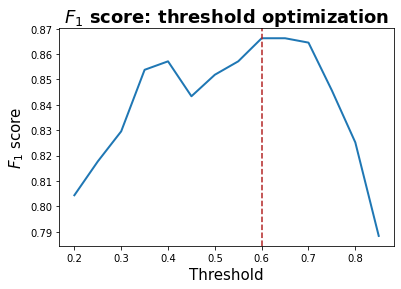

In [31]:
_ = plot_thresh_opt(metrics_df_validation_rgb, save_path)

In [ ]:
# metrics_df_validation_rgb = df_read.copy()

In [ ]:
# x = metrics_df_validation_rgb.Threshold
# y = metrics_df_validation_rgb.F1

In [ ]:
# _ = plt.figure(figsize=(6,3))
# _ = plt.title('$F_1$ score: threshold optimization', size =18, weight='bold')
# _ = plt.ylabel('$F_1$ score', size=15)
# _ = plt.xlabel('Threshold', size=15 )
# _ = plt.plot(x, y, '-o', linewidth=2, markersize=6)
# _ = plt.axvline(0.55, color='firebrick', linestyle='--')
# _ = plt.xticks([0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85], [0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85])
# _ = plt.savefig("paper_yellow/f1_score_train_def_american.png", dpi = 900, bbox_inches='tight' )
# _ = plt.show()

In [ ]:
# plt.figure(figsize=(6,4))
# plt.title('F-1 Score Vs Threshold', size ='x-large', weight='bold')
# plt.ylabel('F-1 Score',size ='large')
# plt.xlabel('Threshold',size ='large' )
# plt.plot(x, y, '-o', linewidth=2, markersize=6)
# plt.savefig('paper_yellow/f1_score_train_def.png')
# plt.show()

# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here